# Vector Representations of Words

https://www.tensorflow.org/tutorials/word2vec

https://github.com/tensorflow/tensorflow/blob/v1.0.0/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

http://mattmahoney.net/dc/textdata

In [1]:
import tensorflow as tf

**Step 1: Download the data.**

In [2]:
import os
import zipfile

HOME_DIR = 'wikipedia'
DATA_DIR = os.path.join(HOME_DIR, 'data')

TRAINING_NAME = 'text8.zip'

TRAINING_FILE = os.path.join(DATA_DIR, TRAINING_NAME)

from tensorflow.contrib.learn.python.learn.datasets.base import maybe_download
maybe_download(TRAINING_NAME, DATA_DIR, 'http://mattmahoney.net/dc/text8.zip')

# Read the data into a list of strings.
with zipfile.ZipFile(TRAINING_FILE) as f:
    first_file = f.namelist()[0]
    text = f.read(first_file).decode('utf-8')
    words = text.split()

In [3]:
text[:500]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso'

In [4]:
del text

In [5]:
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [6]:
len(words)

17005207

**Step 2: Build the dictionary and replace rare words with UNK token.**

In [7]:
%%time

import collections

vocabulary_size = 50000

count = collections.Counter(words).most_common(vocabulary_size - 1) # 'UNK' will be add later

CPU times: user 5.02 s, sys: 10 ms, total: 5.03 s
Wall time: 5 s


In [8]:
count[:10]

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

In [9]:
len(count)

49999

In [10]:
dictionary = dict(UNK=0)
for word, _ in count:
    dictionary[word] = len(dictionary)

In [11]:
list(dictionary.items())[:10]

[('UNK', 0),
 ('the', 1),
 ('of', 2),
 ('and', 3),
 ('one', 4),
 ('in', 5),
 ('a', 6),
 ('to', 7),
 ('zero', 8),
 ('nine', 9)]

In [12]:
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1
    data.append(index)
count.insert(0, ('UNK', unk_count))
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

del words  # Hint to reduce memory.

print('Vocabulary size:')
print(len(dictionary))
print('\nMost common words (+UNK):')
print(count[:5])
print('\nSample data:')
print(data[:10])
print([reverse_dictionary[i] for i in data[:10]])

Vocabulary size:
50000

Most common words (+UNK):
[('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]

Sample data:
[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


**Step 3: Function to generate a training batch for the skip-gram model.**

In [13]:
import random
import numpy as np

class BatchGenerator(object):
    
    def __init__(self, data, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.data = data
        self.data_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        for _ in range(self.window_size):
            self.window_forward()

    def window_forward(self):
        self.window.append(self.data[self.data_index])
        self.data_index = (self.data_index + 1) % len(self.data)


    def read(self):
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)

        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, self.window_size - 1)
                targets_to_avoid.append(target)
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return batch, labels

data_loader = BatchGenerator(data, batch_size=8, num_skips=2, skip_window=1)

print('1st Batch:\n')
batch, labels = data_loader.read()
for i in range(len(batch)):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

print('\n2nd Batch:\n')
batch, labels = data_loader.read()
for i in range(len(batch)):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

1st Batch:

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of

2nd Batch:

2 of -> 3134 abuse
2 of -> 195 term
3134 abuse -> 46 first
3134 abuse -> 2 of
46 first -> 59 used
46 first -> 3134 abuse
59 used -> 46 first
59 used -> 156 against


**Step 4: Build and train a skip-gram model.**

In [14]:
import math

class Word2vecModel(object):
    
    #batch_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #valid_examples
    
    #input_data
    #input_labels
    #loss
    #optimizer
    #normalized_embeddings
    #similarity
    
    def __init__(self,
                 batch_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 valid_examples):
        self.batch_size = batch_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.valid_examples = valid_examples
        
        self.build_graph()
    
    def build_graph(self):
        # Input data.
        self.input_data = tf.placeholder(tf.int32, shape=[self.batch_size])
        self.input_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
        
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -1.0,
                1.0))
        embed = tf.nn.embedding_lookup(embeddings, self.input_data)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, self.embedding_size],
                stddev=1.0 / math.sqrt(self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        # Construct the SGD optimizer using a learning rate of 1.0.
        self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)

        # Compute the cosine similarity between minibatch examples and all embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        self.normalized_embeddings = embeddings / norm
        
        valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32)
        valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings, valid_dataset)
        self.similarity = tf.matmul(valid_embeddings, self.normalized_embeddings, transpose_b=True)

In [15]:
batch_size = 128
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

embedding_size = 128  # Dimension of the embedding vector.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

    m = Word2vecModel(batch_size, vocabulary_size, embedding_size, num_sampled, valid_examples)

    # Add variable initializer.
    init = tf.global_variables_initializer()

**Step 5: Begin training.**

In [16]:
%%time

data_loader = BatchGenerator(data, batch_size, num_skips, skip_window)

num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    session.run(init)
    print('Initialized.\n')

    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = data_loader.read()
        feed_dict = {m.input_data: batch_data, m.input_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([m.optimizer, m.loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step {}: {}'.format(step, average_loss))
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = session.run(m.similarity)
            print()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                nearest_words = (reverse_dictionary[i] for i in nearest)
                print('Nearest to {}: {}'.format(valid_word, ', '.join(nearest_words)))
            print()

    final_embeddings = session.run(m.normalized_embeddings)

Initialized.

Average loss at step 0: 289.1692199707031

Nearest to d: lessened, amex, barrels, chesterfield, bankrupted, kwame, longshanks, communicate
Nearest to or: quarantine, angus, serious, chapel, rowers, studying, ffg, pubescent
Nearest to up: gendarmerie, headshot, nite, potted, hardback, firepower, disparage, transboundary
Nearest to will: schubert, dye, remonstrance, mephisto, starboard, longbow, talmadge, landless
Nearest to of: likeness, allegory, pruitt, proves, serre, programming, horst, indus
Nearest to into: novella, inactive, hypothesized, wove, callimico, treat, blanton, mitochondria
Nearest to two: contractor, repubblica, catchy, dora, ram, guantanamo, spell, heinz
Nearest to called: switched, lerner, terminates, utc, definitive, rebuked, dramatist, portfolio
Nearest to would: ghaznavid, adolph, increase, scheduler, koine, trickle, chewing, currency
Nearest to so: here, prints, shroud, mayflower, bump, annales, yahoo, oahu
Nearest to i: zuid, extremists, dawson, val

**Step 6: Visualize the embeddings.**

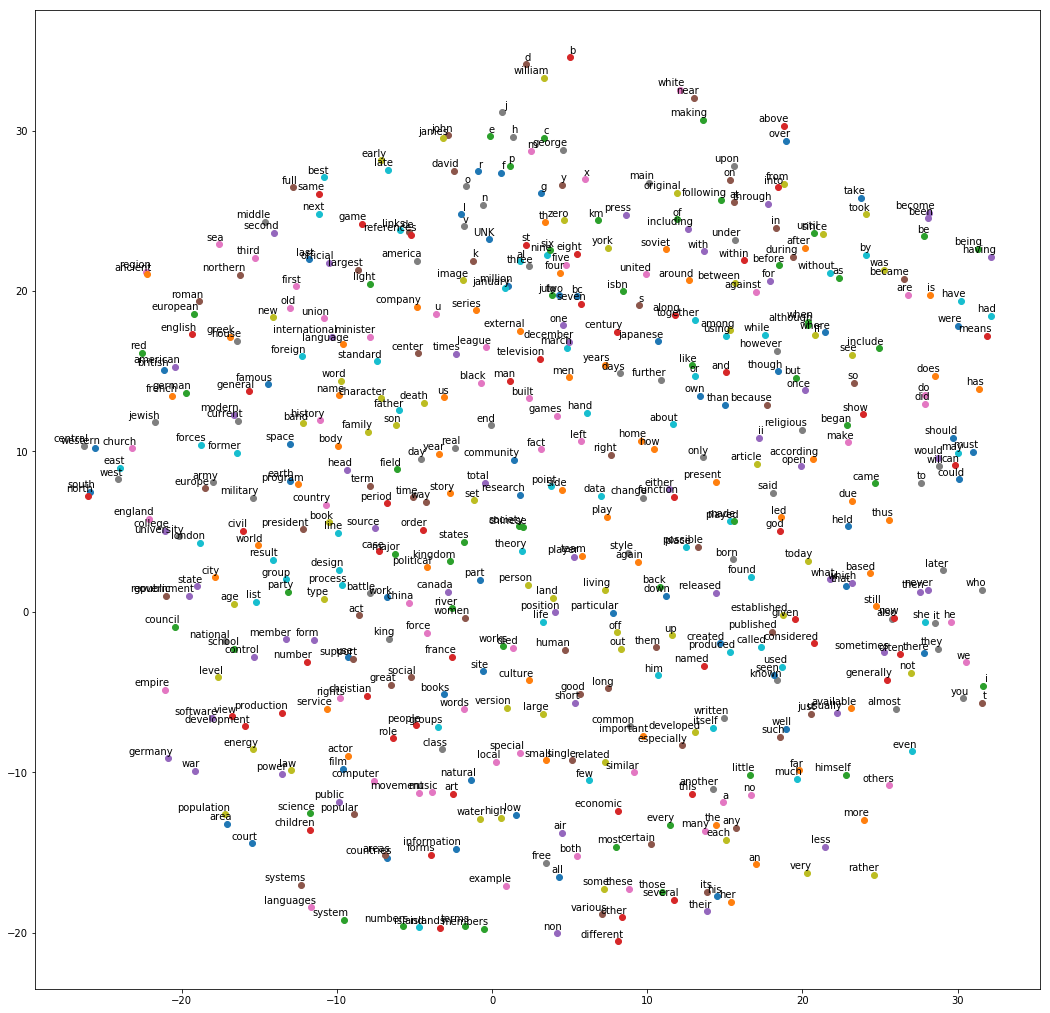

In [18]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

plt.show()